In [218]:
# Imports needed for the script
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

In [219]:
artists_billboard = pd.read_csv(r"artists_billboard_fix3.csv")
artists_billboard.shape


(635, 11)

In [220]:
artists_billboard.head()

,id,title,artist,mood,tempo,genre,artist_type,chart_date,durationSeg,top,anioNacimiento
0,0,Small Town Throwdown,BRANTLEY GILBERT featuring JUSTIN MOORE & THOM...,Brooding,Medium Tempo,Traditional,Male,20140628,191.0,0,1975.0
1,1,Bang Bang,"JESSIE J, ARIANA GRANDE & NICKI MINAJ",Energizing,Medium Tempo,Pop,Female,20140816,368.0,0,1989.0
2,2,Timber,PITBULL featuring KE$HA,Excited,Medium Tempo,Urban,Mixed,20140118,223.0,1,1993.0
3,3,Sweater Weather,THE NEIGHBOURHOOD,Brooding,Medium Tempo,Alternative & Punk,Male,20140104,206.0,0,1989.0
4,4,Automatic,MIRANDA LAMBERT,Yearning,Medium Tempo,Traditional,Female,20140301,232.0,0,0.0


In [221]:
artists_billboard.groupby('top').size()

top
0    494
1    141
dtype: int64

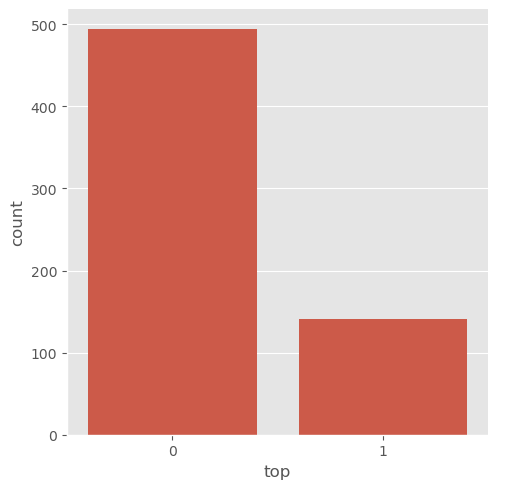

In [222]:
sb.catplot(x='top', data=artists_billboard, kind='count')

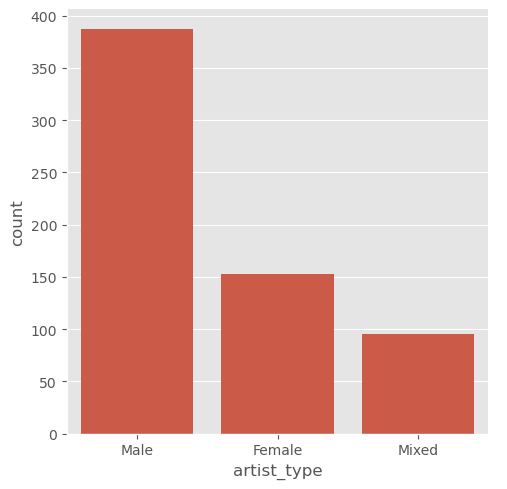

In [223]:
sb.catplot(x='artist_type', data=artists_billboard, kind='count')

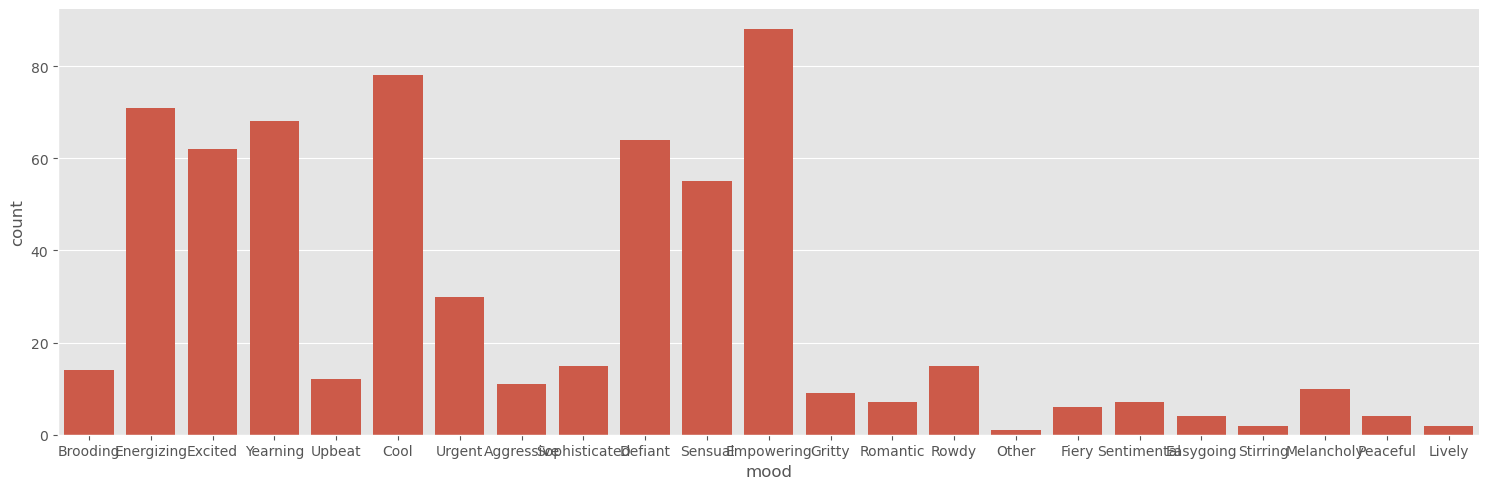

In [224]:
sb.catplot(x='mood',data=artists_billboard,kind="count", aspect=3)

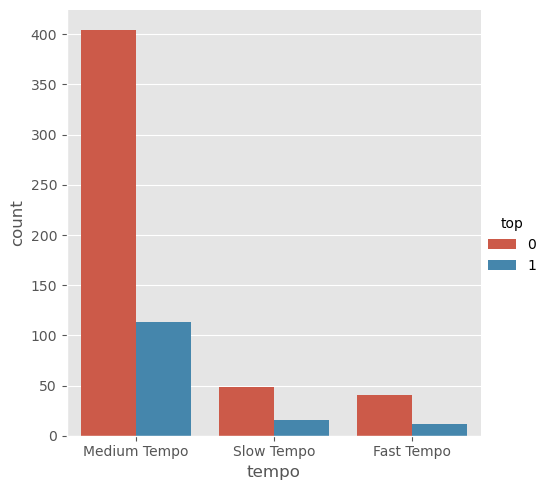

In [225]:
sb.catplot(x='tempo',data=artists_billboard,hue='top',kind="count")

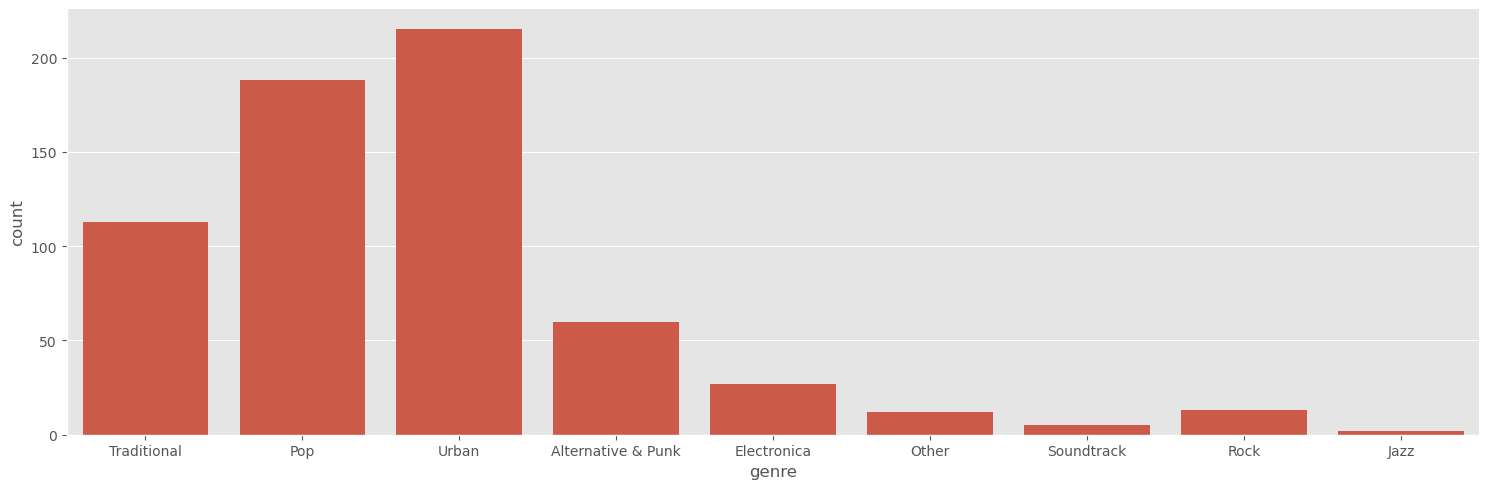

In [226]:
sb.catplot(x='genre',data=artists_billboard,kind="count", aspect=3)

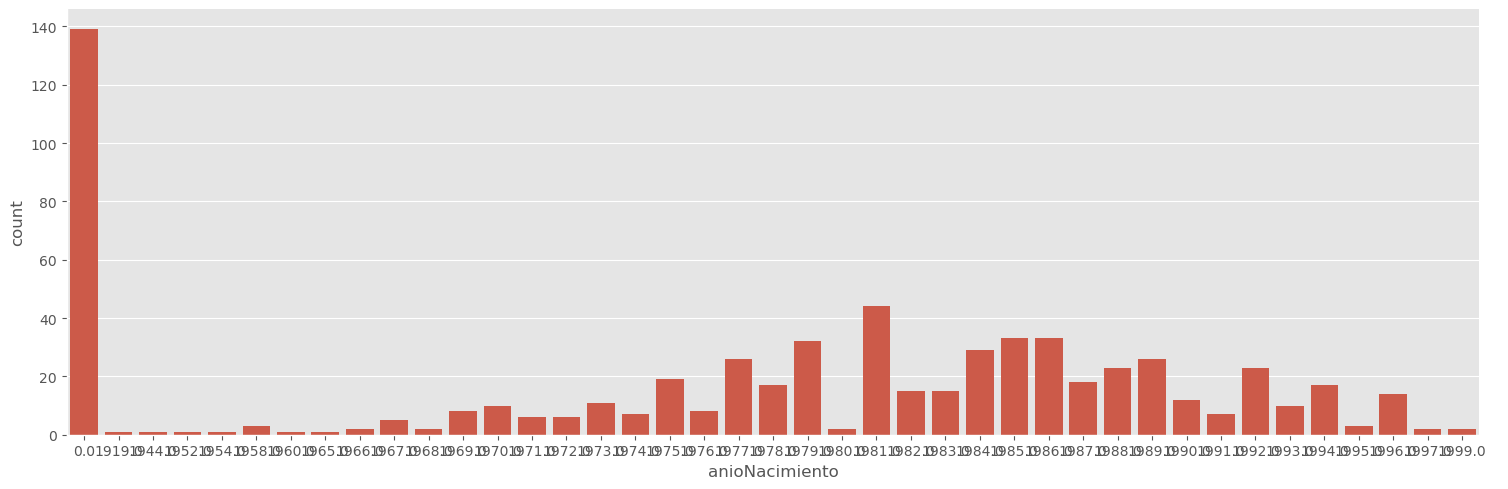

In [227]:
sb.catplot(x='anioNacimiento',data=artists_billboard,kind="count", aspect=3)

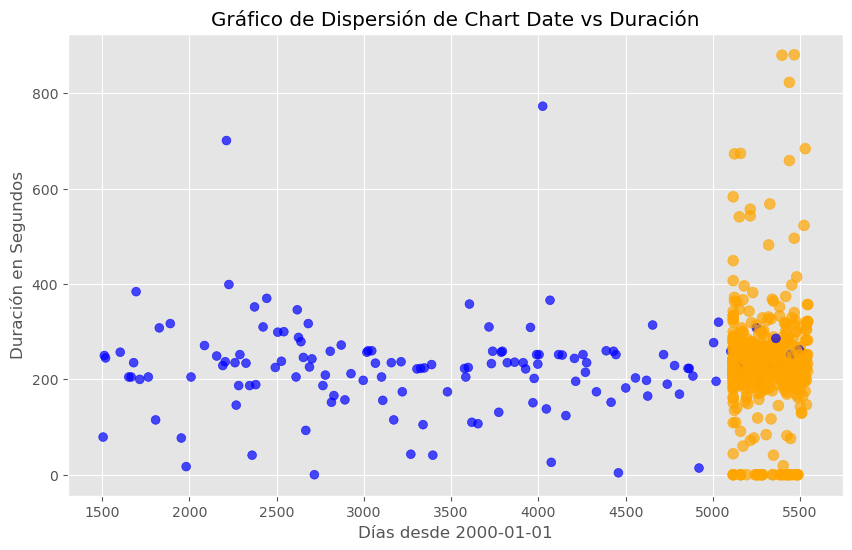

In [228]:
# Convertir 'chart_date' de entero a cadena y luego a datetime
artists_billboard['chart_date'] = artists_billboard['chart_date'].astype(str)
artists_billboard['chart_date'] = pd.to_datetime(artists_billboard['chart_date'], format='%Y%m%d')

# Definir la fecha base para la conversión a números
base_date = pd.Timestamp('2000-01-01')

# Convertir 'chart_date' a números (días desde la fecha base)
artists_billboard['chart_date_num'] = (artists_billboard['chart_date'] - base_date).dt.total_seconds() / (60 * 60 * 24)  # Convertir a días

# Datos para el gráfico
f1 = artists_billboard['chart_date_num'].values
f2 = artists_billboard['durationSeg'].values

# Definir colores y tamaños
colores = ['orange', 'blue']  # si no estaban definidos previamente
tamanios = [60, 40]  # si no estaban definidos previamente

# Asignar colores y tamaños según 'top'
asignar = []
asignar2 = []

for index, row in artists_billboard.iterrows():
    color_index = row['top'] % len(colores)  # Asegúrate de que 'top' contiene índices válidos
    size_index = row['top'] % len(tamanios)
    asignar.append(colores[color_index])
    asignar2.append(tamanios[size_index])

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(f1, f2, c=asignar, s=asignar2, alpha=0.7)  # alpha para la transparencia
plt.xlabel('Días desde 2000-01-01')
plt.ylabel('Duración en Segundos')
plt.title('Gráfico de Dispersión de Chart Date vs Duración')
plt.grid(True)
plt.show()

In [229]:
def edad_fix(anio):
    if anio==0:
        return None
    return anio
 
artists_billboard['anioNacimiento']=artists_billboard.apply(lambda x: edad_fix(x['anioNacimiento']), axis=1);

In [230]:
def calcula_edad(anio,cuando):
    cad = str(cuando)
    momento = cad[:4]
    if anio==0.0:
        return None
    return int(momento) - anio
 
artists_billboard['edad_en_billboard']=artists_billboard.apply(lambda x: calcula_edad(x['anioNacimiento'],x['chart_date']), axis=1);

In [231]:
age_avg = artists_billboard['edad_en_billboard'].mean()
age_std = artists_billboard['edad_en_billboard'].std()
age_null_count = artists_billboard['edad_en_billboard'].isnull().sum()
age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
 
conValoresNulos = np.isnan(artists_billboard['edad_en_billboard'])
 
artists_billboard.loc[np.isnan(artists_billboard['edad_en_billboard']), 'edad_en_billboard'] = age_null_random_list
artists_billboard['edad_en_billboard'] = artists_billboard['edad_en_billboard'].astype(int)
print("Edad Promedio: " + str(age_avg))
print("Desvió Std Edad: " + str(age_std))
print("Intervalo para asignar edad aleatoria: " + str(int(age_avg - age_std)) + " a " + str(int(age_avg + age_std)))

Edad Promedio: 30.10282258064516
Desvió Std Edad: 8.40078832861513
Intervalo para asignar edad aleatoria: 21 a 38


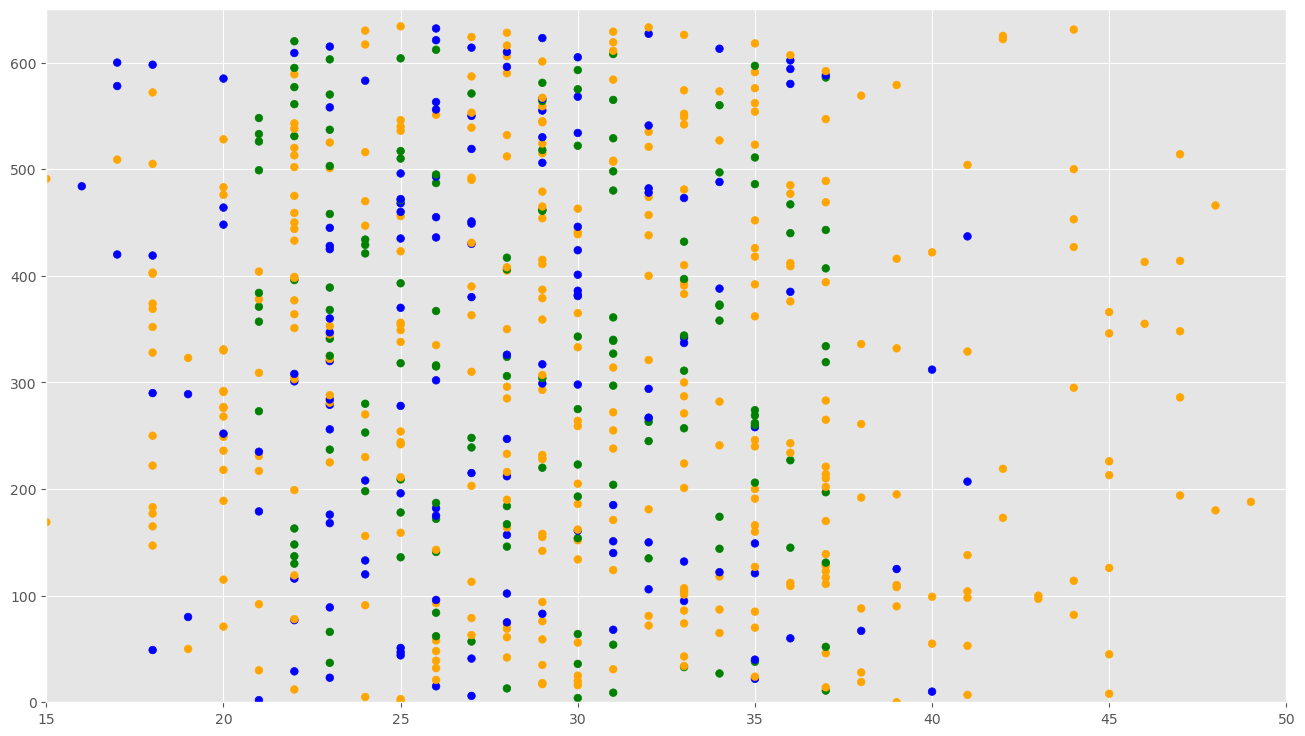

In [232]:
f1 = artists_billboard['edad_en_billboard'].values
f2 = artists_billboard.index
 
colores = ['orange','blue','green']
 
asignar=[]
for index, row in artists_billboard.iterrows():    
    if (conValoresNulos[index]):
        asignar.append(colores[2]) # verde
    else:
        asignar.append(colores[row['top']])
 
plt.scatter(f1, f2, c=asignar, s=30)
plt.axis([15,50,0,650])
plt.show()

In [233]:
# Mood Mapping 
artists_billboard['moodEncoded'] = artists_billboard['mood'].map( {'Energizing': 6, 
                                        'Empowering': 6,
                                        'Cool': 5, 
                                        'Yearning': 4, # anhelo, deseo, ansia
                                        'Excited': 5, #emocionado
                                        'Defiant': 3, 
                                        'Sensual': 2, 
                                        'Gritty': 3, #coraje 
                                        'Sophisticated': 4,
                                        'Aggressive': 4, # provocativo
                                        'Fiery': 4, #caracter fuerte
                                        'Urgent': 3, 
                                        'Rowdy': 4, #ruidoso alboroto
                                        'Sentimental': 4,
                                        'Easygoing': 1, # sencillo
                                        'Melancholy': 4, 
                                        'Romantic': 2, 
                                        'Peaceful': 1, 
                                        'Brooding': 4, # melancolico
                                        'Upbeat': 5, #optimista alegre
                                        'Stirring': 5, #emocionante
                                        'Lively': 5, #animado
                                        'Other': 0,'':0} ).astype(int)
# Tempo Mapping 
artists_billboard['tempoEncoded'] = artists_billboard['tempo'].map( {'Fast Tempo': 0, 'Medium Tempo': 2, 'Slow Tempo': 1, '': 0} ).astype(int)
# Genre Mapping 
artists_billboard['genreEncoded'] = artists_billboard['genre'].map( {'Urban': 4, 
                                          'Pop': 3, 
                                          'Traditional': 2, 
                                          'Alternative & Punk': 1,
                                         'Electronica': 1, 
                                          'Rock': 1, 
                                          'Soundtrack': 0, 
                                          'Jazz': 0,
                                          'Other':0,'':0} 
                                       ).astype(int)
# artist_type Mapping 
artists_billboard['artist_typeEncoded'] = artists_billboard['artist_type'].map( {'Female': 2, 'Male': 3, 'Mixed': 1, '': 0} ).astype(int)
 
 
# Mapping edad en la que llegaron al billboard
artists_billboard.loc[ artists_billboard['edad_en_billboard'] <= 21, 'edadEncoded']                         = 0
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 21) & (artists_billboard['edad_en_billboard'] <= 26), 'edadEncoded'] = 1
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 26) & (artists_billboard['edad_en_billboard'] <= 30), 'edadEncoded'] = 2
artists_billboard.loc[(artists_billboard['edad_en_billboard'] > 30) & (artists_billboard['edad_en_billboard'] <= 40), 'edadEncoded'] = 3
artists_billboard.loc[ artists_billboard['edad_en_billboard'] > 40, 'edadEncoded'] = 4
 
# Mapping Song Duration
artists_billboard.loc[ artists_billboard['durationSeg'] <= 150, 'durationEncoded']                          = 0
artists_billboard.loc[(artists_billboard['durationSeg'] > 150) & (artists_billboard['durationSeg'] <= 180), 'durationEncoded'] = 1
artists_billboard.loc[(artists_billboard['durationSeg'] > 180) & (artists_billboard['durationSeg'] <= 210), 'durationEncoded'] = 2
artists_billboard.loc[(artists_billboard['durationSeg'] > 210) & (artists_billboard['durationSeg'] <= 240), 'durationEncoded'] = 3
artists_billboard.loc[(artists_billboard['durationSeg'] > 240) & (artists_billboard['durationSeg'] <= 270), 'durationEncoded'] = 4
artists_billboard.loc[(artists_billboard['durationSeg'] > 270) & (artists_billboard['durationSeg'] <= 300), 'durationEncoded'] = 5
artists_billboard.loc[ artists_billboard['durationSeg'] > 300, 'durationEncoded'] = 6

In [234]:
drop_elements = ['id','title','artist','mood','tempo','genre','artist_type','chart_date','anioNacimiento','durationSeg','edad_en_billboard']
artists_encoded = artists_billboard.drop(drop_elements, axis = 1)

In [235]:
artists_encoded[['moodEncoded', 'top']].groupby(['moodEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

moodEncoded       top          
                   mean count sum
0           0  0.000000     1   0
1           1  0.000000     8   0
2           2  0.274194    62  17
3           3  0.145631   103  15
4           4  0.136986   146  20
5           5  0.294872   156  46
6           6  0.270440   159  43

In [236]:
artists_encoded[['artist_typeEncoded', 'top']].groupby(['artist_typeEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

artist_typeEncoded       top          
                          mean count sum
0                  1  0.305263    95  29
1                  2  0.320261   153  49
2                  3  0.162791   387  63

In [237]:
artists_encoded[['genreEncoded', 'top']].groupby(['genreEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

genreEncoded       top          
                    mean count sum
0            0  0.105263    19   2
1            1  0.070000   100   7
2            2  0.008850   113   1
3            3  0.319149   188  60
4            4  0.330233   215  71

In [238]:
artists_encoded[['tempoEncoded', 'top']].groupby(['tempoEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

tempoEncoded       top           
                    mean count  sum
0            0  0.226415    53   12
1            1  0.246154    65   16
2            2  0.218569   517  113

In [239]:
artists_encoded[['durationEncoded', 'top']].groupby(['durationEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

durationEncoded       top          
                       mean count sum
0             0.0  0.277778    72  20
1             1.0  0.333333    33  11
2             2.0  0.211009   109  23
3             3.0  0.202381   168  34
4             4.0  0.238938   113  27
5             5.0  0.140351    57   8
6             6.0  0.216867    83  18

In [240]:
artists_encoded[['edadEncoded', 'top']].groupby(['edadEncoded'], as_index=False).agg(['mean', 'count', 'sum'])

edadEncoded       top          
                   mean count sum
0         0.0  0.250000    68  17
1         1.0  0.302469   162  49
2         2.0  0.253425   146  37
3         3.0  0.169811   212  36
4         4.0  0.042553    47   2

In [241]:
cv = KFold(n_splits=10) # Numero deseado de "folds" que haremos
accuracies = list()
max_attributes = len(list(artists_encoded))
depth_range = range(1, max_attributes + 1)
 
# Testearemos la profundidad de 1 a cantidad de atributos +1
for depth in depth_range:
    fold_accuracy = []
    tree_model = tree.DecisionTreeClassifier(criterion='entropy',
                                             min_samples_split=20,
                                             min_samples_leaf=5,
                                             max_depth = depth,
                                             class_weight={1:3.5})
    for train_fold, valid_fold in cv.split(artists_encoded):
        f_train = artists_encoded.loc[train_fold] 
        f_valid = artists_encoded.loc[valid_fold] 
 
        model = tree_model.fit(X = f_train.drop(['top'], axis=1), 
                               y = f_train["top"]) 
        valid_acc = model.score(X = f_valid.drop(['top'], axis=1), 
                                y = f_valid["top"]) # calculamos la precision con el segmento de validacion
        fold_accuracy.append(valid_acc)
 
    avg = sum(fold_accuracy)/len(fold_accuracy)
    accuracies.append(avg)
    
# Mostramos los resultados obtenidos
df = pd.DataFrame({"Max Depth": depth_range, "Average Accuracy": accuracies})
df = df[["Max Depth", "Average Accuracy"]]
print(df.to_string(index=False))

 Max Depth  Average Accuracy
         1          0.982763
         2          0.982763
         3          0.982763
         4          0.982763
         5          0.968477
         6          0.968576
         7          0.959127
         8          0.959127


In [242]:
# Crear arrays de entrenamiento y las etiquetas que indican si llegó a top o no 
y_train = artists_encoded['top']
x_train = artists_encoded.drop(['top'], axis=1).values 
 
# Crear Arbol de decision con profundidad = 4
decision_tree = tree.DecisionTreeClassifier(criterion='entropy',
                                            min_samples_split=20,
                                            min_samples_leaf=5,
                                            max_depth = 4,
                                            class_weight={1:3.5})
decision_tree.fit(x_train, y_train)
 
# exportar el modelo a archivo .dot
with open(r"tree1.dot", 'w') as f:
     f = tree.export_graphviz(decision_tree,
                              out_file=f,
                              max_depth = 7,
                              impurity = True,
                              feature_names = list(artists_encoded.drop(['top'], axis=1)),
                              class_names = ['No', 'N1 Billboard'],
                              rounded = True,
                              filled= True )
        
# Convertir el archivo .dot a png para poder visualizarlo
check_call(['dot','-Tpng',r'tree1.dot','-o',r'tree1.png'])
PImage("tree1.png")

FileNotFoundError: [WinError 2] El sistema no puede encontrar el archivo especificado

In [ ]:
acc_decision_tree = round(decision_tree.score(x_train, y_train) * 100, 2)
print(acc_decision_tree)

98.43


In [244]:
#predecir artista CAMILA CABELLO featuring YOUNG THUG
# con su canción Havana llego a numero 1 Billboard US en 2017
 
# Definir las columnas en el mismo orden que las características usadas en el modelo
columnas = ['chart_date_num', 'moodEncoded', 'tempoEncoded', 'genreEncoded', 'artist_typeEncoded', 'edadEncoded', 'durationEncoded']

# Crear el DataFrame de prueba con las columnas en el orden correcto
x_test = pd.DataFrame(columns=columnas)
x_test.loc[0] = (20010628, 5, 2, 4, 1, 0, 3)

# Hacer la predicción
y_pred = decision_tree.predict(x_test)
print("Predicción: " + str(y_pred))

# Obtener las probabilidades de las clases
y_proba = decision_tree.predict_proba(x_test)
# La clase predicha está en y_pred[0], así que obtenemos la probabilidad correspondiente
print("Probabilidad de Acierto: " + str(round(y_proba[0][y_pred[0]] * 100, 2)) + "%")

Predicción: [0]
Probabilidad de Acierto: 90.79%


d:\anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
d:\anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [243]:
# Definir las columnas en el mismo orden que las características usadas en el modelo
columnas = ['chart_date_num', 'moodEncoded', 'tempoEncoded', 'genreEncoded', 'artist_typeEncoded', 'edadEncoded', 'durationEncoded']

# Crear el DataFrame de prueba con las columnas en el orden correcto
x_test = pd.DataFrame(columns=columnas)
x_test.loc[0] = (19870628, 4, 2, 1, 3, 2, 3)

# Hacer la predicción
y_pred = decision_tree.predict(x_test)
print("Predicción: " + str(y_pred))

# Obtener las probabilidades de las clases
y_proba = decision_tree.predict_proba(x_test)
# La clase predicha está en y_pred[0], así que obtenemos la probabilidad correspondiente
print("Probabilidad de Acierto: " + str(round(y_proba[0][y_pred[0]] * 100, 2)) + "%")



Predicción: [0]
Probabilidad de Acierto: 100.0%


d:\anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
d:\anaconda\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
